# Desarrollo de un sistema de diagnóstico de enfermedades en hojas de tomate mediante PlantCV y modelos de aprendizaje profundo

El conjunto de datos contiene más de 20.000 imágenes de hojas de tomate divididas en 11 clases (10 tipos de enfermedades y 1 clase de hojas sanas). Las imágenes se recogieron tanto en entornos de laboratorio como en condiciones naturales. El objetivo de este proyecto es crear un modelo capaz de detectar las enfermedades de las hojas del tomate y que pueda utilizarse en múltiples plataformas.

## Carga de datos de kaggle

In [1]:
%%capture
!pip install --upgrade --force-reinstall --no-deps kaggle

In [2]:
import io
from google.colab import files

seed = 42  # Semilla aleatoria arbitraria y constante a incluir en los algoritmos estocásticos para que los experimentos sean siempre reproducibles por el profesor.

def upload_files (index_fields=None):
  uploaded = files.upload()

In [3]:
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubnmarnlucas","key":"ee4416738920302b11db77b835dab47e"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d ashishmotwani/tomato

Dataset URL: https://www.kaggle.com/datasets/ashishmotwani/tomato
License(s): copyright-authors
 96% 1.32G/1.37G [00:12<00:00, 88.9MB/s]
100% 1.37G/1.37G [00:12<00:00, 121MB/s] 


In [6]:
!mkdir my_dataset

In [7]:
%%capture
!unzip tomato.zip -d my_dataset

In [8]:
!ls my_dataset/

train  valid


In [9]:
!ls my_dataset/train

 Bacterial_spot   Septoria_leaf_spot
 Early_blight	 'Spider_mites Two-spotted_spider_mite'
 healthy	  Target_Spot
 Late_blight	  Tomato_mosaic_virus
 Leaf_Mold	  Tomato_Yellow_Leaf_Curl_Virus
 powdery_mildew


In [10]:
!ls my_dataset/train/Bacterial_spot

'00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG'
'0045ba29-ed1b-43b4-afde-719cc7adefdb___GCREC_Bact.Sp 6254.JPG'
'00639d29-2d1a-4fcf-9bd3-a2b3109c74c4___UF.GRC_BS_Lab Leaf 1054.JPG'
'00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'
'00a7c269-3476-4d25-b744-44d6353cd921___GCREC_Bact.Sp 5807.JPG'
'00b7e89a-e129-4576-b51f-48923888bff9___GCREC_Bact.Sp 6202.JPG'
'01375198-62af-4c40-bddf-f3c11107200b___GCREC_Bact.Sp 5914.JPG'
'01a3cf3f-94c1-44d5-8972-8c509d62558e___GCREC_Bact.Sp 3396.JPG'
'01a46cb5-d354-4f59-868e-e56186701541___GCREC_Bact.Sp 5638.JPG'
'01e079ba-939a-4681-8983-db663f4a859b___GCREC_Bact.Sp 3029.JPG'
'01f13167-f508-4ef2-8720-4e973438f8fc___GCREC_Bact.Sp 5892.JPG'
'02626a44-a613-4402-a6b0-243858736e32___GCREC_Bact.Sp 3191.JPG'
'02a0f70a-9e27-420e-93ff-6ed8105f41c1___GCREC_Bact.Sp 3570.JPG'
'02dfe58f-0ad1-4bf6-838a-e145978b1eed___GCREC_Bact.Sp 5841.JPG'
'02fd4e60-db82-441c-87f6-08de768a4462___GCREC_Bact.Sp 5547.JPG'
'030501db-683b-4ed5-9ec0-c475a5dfdd

Hasta ahora se ha descargado el dataset de kaggle https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset en un zip y se ha descomprimido en la carpeta my_dataset/. Se ha comprobado que estedirectorio contiene otros directorios con ciertas imágenes. Parece que hay distintos tipos de imágenes como .png o .jpeg.

## Exploración de directorio

In [11]:
%%capture
!pip install plantcv

In [12]:
import os
import random
import shutil
from collections import Counter
import matplotlib.pyplot as plt

from plantcv import plantcv as pcv

In [13]:
def explore_directory(dir, top_k):

    size_counter = Counter()
    example_paths = {}
    error_imgs = 0

    if os.path.exists(dir): # Verifica si existe el directorio

        for subdir in os.listdir(dir): # Recorre subdirectorios:
            subdirPath = os.path.join(dir, subdir)
            if os.path.isdir(subdirPath): # Comprueba que está en un directorio
                for file in os.listdir(subdirPath):
                    filePath = os.path.join(subdirPath, file) # Ruta completa de cada archivo
                    if os.path.isfile(filePath): # Verifica si es un archivo
                        img_path = os.path.join(filePath)
                        try:
                            img, _, _ = pcv.readimage(filename=img_path)
                            height, width = img.shape[:2]
                            size = (width, height)
                            size_counter[size] += 1
                            if size not in example_paths:
                                example_paths[size] = img_path
                        except:
                            error_imgs += 1
                            continue  # skip corrupted or unreadable images
                    else:
                      print("No es un archivo")
            else:
                print("No es un directorio")
    else:
        print("El directorio especificado no existe")


    # Mostrar los tamaños más comunes
    most_common_sizes = size_counter.most_common(top_k)
    print(f"Tamaño de imagen más común (Top {top_k}):")
    for size, count in most_common_sizes:
        print(f"  {size} → {count} imágenes")

    print(f"\nNúmero de tamaños de imágenes diferentes: {len(size_counter)}")

    print(f"\nNúmero de imágenes ilegibles: {error_imgs}")

In [14]:
explore_directory('my_dataset/train/', 5)

Tamaño de imagen más común (Top 5):
  (256, 256) → 18942 imágenes
  (227, 227) → 4120 imágenes
  (640, 640) → 1207 imágenes
  (533, 800) → 151 imágenes
  (800, 600) → 10 imágenes

Número de tamaños de imágenes diferentes: 760

Número de imágenes ilegibles: 0


In [15]:
def plot_random_images_per_class(dir):

  classes = sorted(os.listdir(dir))# Listar subdirectorios (clases)

  plt.figure(figsize=(15, 8))  # Crear figura

  for i, cls in enumerate(classes):
    cls_dir = os.path.join(dir, cls)
    if os.path.isdir(cls_dir): # Comprueba que es en un directorio
      images = [f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))] # Filtra archivos de tipo .jpg, .jpeg, .png (imagen)
      img_path = os.path.join(cls_dir, random.choice(images)) # Elegir una imagen aleatoria
      img, _, _ = pcv.readimage(filename=img_path) # Leer imagen

      # Dibujar en un subplot
      plt.subplot(3, 4, i+1)  # ajusta según nº de clases
      plt.imshow(img)
      plt.title(cls, fontsize=14)
      plt.axis("off")

  plt.tight_layout()
  plt.show()

Se observa la variedad de imágenes que existen. Unas más oscuras, otras con más brillo. Algunas con fundo blanco, otras con fondo de color o incluso con más elementos de fondo no solo un fondo plano. Incluso algunas están giradas.

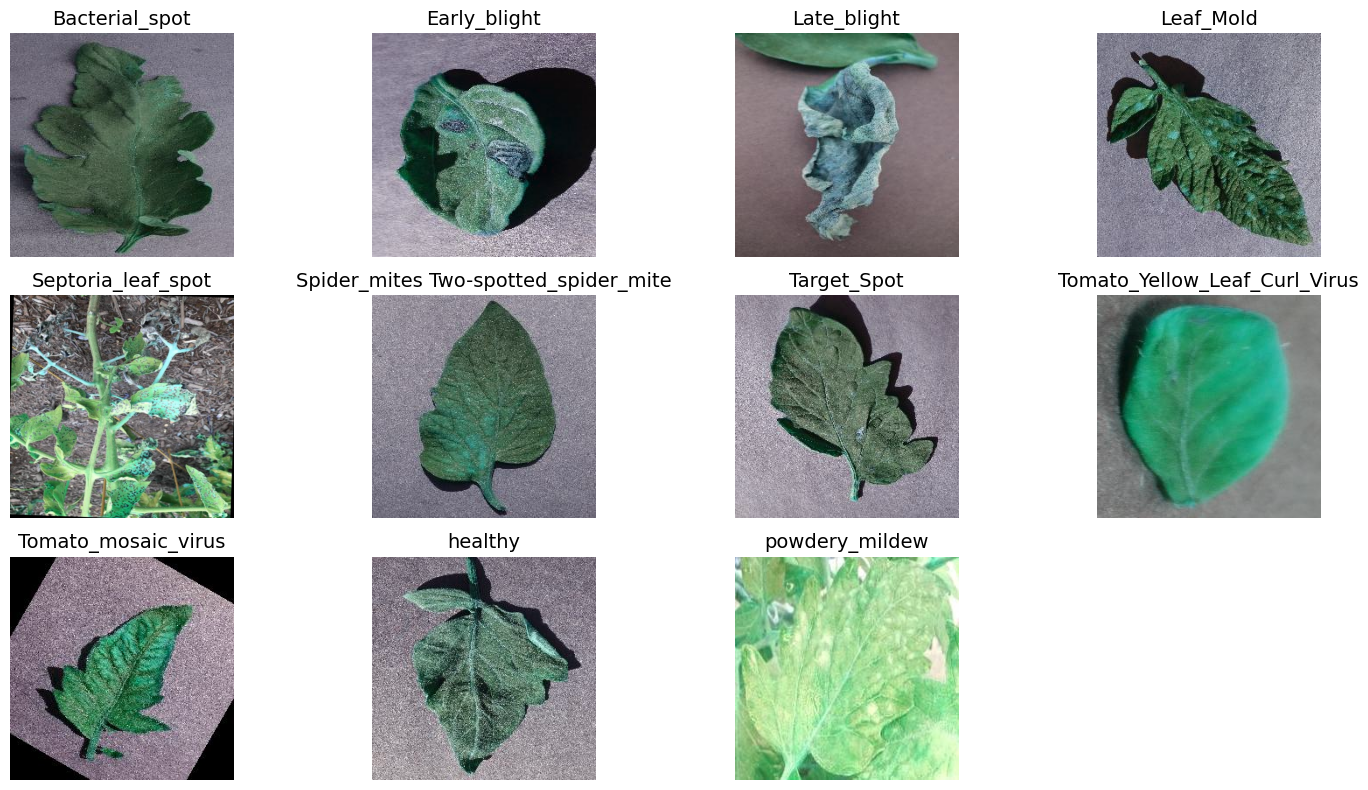

In [16]:
plot_random_images_per_class('my_dataset/train/')

## Preprocesamiento

In [17]:
%%capture
!pip install tensorflow

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import TFSMLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from PIL import Image

Después de haber ejecutado el preprocesamiento y empezar con el modelado se encontró un error con los datasets. Básicamente existen algunas imágenes que están corruptas (incompletas, mal guardadas) o tienen un formato raro (por ejemplo, CMYK en vez de RGB, o metadatos que confunden a una función de tensorflow que se usa para balancear las clases). Por lo tanto se van a mostrar las imágenes que producen eso y se van a convertir a rgb.

In [19]:
def check_tf_readable(directory):
    bad_files = []
    for root, _, files in os.walk(directory):
        for f in files:
            path = os.path.join(root, f)
            try:
                img_bytes = tf.io.read_file(path)
                tf.io.decode_image(img_bytes)  # <- Usa el decodificador de TensorFlow
            except:
                bad_files.append(path)
    return bad_files

In [20]:
bad_train = check_tf_readable("my_dataset/train")
bad_val = check_tf_readable("my_dataset/valid")

print("Imágenes problemáticas en train:", len(bad_train))
print("Imágenes problemáticas en valid:", len(bad_val))

print("Train:", bad_train[:10])
print("Valid:", bad_val[:10])

Imágenes problemáticas en train: 1
Imágenes problemáticas en valid: 1
Train: ['my_dataset/train/healthy/edible-tomato-leaves.jpg']
Valid: ['my_dataset/valid/healthy/2013-08-20-05.jpg']


In [21]:
# Lista de imágenes problemáticas
bad_train = ['my_dataset/train/healthy/edible-tomato-leaves.jpg']
bad_val = ['my_dataset/valid/healthy/2013-08-20-05.jpg']

for img_path in bad_train + bad_val:
    try:
        img = Image.open(img_path).convert('RGB')  # Forzar RGB
        img.save(img_path)  # Sobrescribe el archivo
        print("Re-guardada:", img_path)
    except Exception as e:
        print("No se pudo convertir:", img_path, e)

Re-guardada: my_dataset/train/healthy/edible-tomato-leaves.jpg
Re-guardada: my_dataset/valid/healthy/2013-08-20-05.jpg


Después de este ajuste se comienza con el preprocesamiento propiamente dicho

En el conjunto de datos no hay ninguna carpeta de pruebas (test). Por lo tanto, tenemos que mover algunas imágenes de la carpeta de entrenamiento a una nueva carpeta llamada test. Utilizando una proporción del 20%.

In [22]:
train_dir = "my_dataset/train/"
test_dir = 'my_dataset/test/'

# Proporción de datos para el conjunto de test
test_ratio = 0.2

# Semilla para aleatorización
random.seed(42)

# Bucle para recorrer cada clase (directorio) del directorio de entrenamiento
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        # Crear directorio test/<class> si no existe
        target_class_path = os.path.join(test_dir, class_name)
        os.makedirs(target_class_path, exist_ok=True)

        # Lista de imágenes en directorio de cada clase
        images = [
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f))
        ]
        random.shuffle(images)  # Aleatorizar imágenes

        # Cuántas imágenes pasan a conjunto de test
        n_test = int(len(images) * test_ratio)
        test_images = images[:n_test]

        # Mueve la imagen al directorio de test
        for img_name in test_images:
            src_path = os.path.join(class_path, img_name)
            dst_path = os.path.join(target_class_path, img_name)
            shutil.move(src_path, dst_path)

    else:
        print('No es un directorio:', class_path)

Se forma el conjunto de datos de entrenamiento, validación y test a partir de los directorios donde se encuentran las imágenes. Éstas se convertirán a tamaño 224x224 píxeles (ya que es el tamaño más común, para los modelos) y se procesarán en lotes de 16. Se generarán a partir de ImageDataGenerator que nos permitirá normalizar las imágenes de los tres conjuntos, y a su vez aplicar la técnica de data aumentation para el conjunto de datos de entrenamiento.

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalizar píxeles de la imagen de 0-255 a 0-1
    rotation_range=20, # Rota aleatoriamente la imagen hasta ±20 grados
    zoom_range=0.2, # Aplica un zoom aleatorio entre 80% y 120% del tamaño original
    width_shift_range=0.2, # Desplaza la imagen horizontalmente hasta un 20% de su ancho
    height_shift_range=0.2, # Desplaza la imagen verticalmente hasta un 20% de su alto
    shear_range=0.15, # Aplica una transformación de cizallamiento (shear), como si deformaras la imagen en diagonal
    horizontal_flip=True, # Gira horizontalmente las imágenes aleatoriamente
    brightness_range=[0.8, 1.2], # Cambia el brillo aleatoriamente entre 80% y 120%
    fill_mode='nearest' # Cuando una transformación (como una rotación o desplazamiento) deja espacios vacíos en la imagen, estos se rellenan con el valor del píxel más cercano
)

val_datagen = ImageDataGenerator(rescale=1./255) # Normalizar píxeles de la imagen de 0-255 a 0-1
test_datagen = ImageDataGenerator(rescale=1./255) # Normalizar píxeles de la imagen de 0-255 a 0-1

In [24]:
valid_dir = "my_dataset/valid/"

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_generator = train_datagen.flow_from_directory(
    train_dir, # Directorio con imágenes para entrenamiento
    target_size = IMG_SIZE, # Tamaño de imágenes 256x256
    batch_size = BATCH_SIZE, # Imágenes por lote 32
    class_mode = 'categorical', # Etiquetas en formato one-hot (clasificación multiclase)
    shuffle = True, # Aleatorizar los datos para mejorar generalización de modelo
    seed = 42 # Semilla para aleatorización
)


val_generator = val_datagen.flow_from_directory(
    valid_dir,  # Directorio con imágenes para validación
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False, # No aleatorizado
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,   # Directorio con imágenes para pruebas
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False, # No aleatorizado
    seed = 42
)

Found 20686 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.
Found 5165 images belonging to 11 classes.


El aumento de datos solo se aplicará al conjunto de entrenamiento. Los datos de validación y prueba sólo utilizan la normalización, ya que el objetivo de estos es que sean representativas de los datos originales, sin aumentos, para una evaluación más objetiva del rendimiento del modelo.

La salida muestra el número total de imágenes en cada subconjunto del conjunto de datos:
*   **Entrenamiento:** Hay 20.686 imágenes utilizadas para entrenar el modelo. Se trata de la mayor parte de los datos, ya que el modelo necesita muchos ejemplos para aprender patrones.
*   **Validación:** Hay 6.683 imágenes para la validación. Estos datos se utilizan para evaluar el rendimiento del modelo durante el entrenamiento, sin afectar a los parámetros del modelo.
*   **Prueba:** Hay 5.165 imágenes para la prueba final. Este conjunto de datos se utiliza una vez finalizado el entrenamiento para medir objetivamente el rendimiento del modelo con datos nuevos que nunca se han visto.


Ahora se mostrarán datos relevantes a tener en cuenta para el entrenamiento

In [25]:
num_batches = len(train_generator)
print('Número total de lotes:', num_batches)

Número total de lotes: 647


In [26]:
images, labels = next(train_generator)

print('Estructura del lote de imágenes:', images.shape) # (BATCH_SIZE, IMG_SIZE, 3)
print('Estructura del lote de etiquetas:', labels.shape) # (BATCH_SIZE, num_clases)

Estructura del lote de imágenes: (32, 224, 224, 3)
Estructura del lote de etiquetas: (32, 11)


In [27]:
class_names = list(train_generator.class_indices.keys())

print("Clases:", class_names)

Clases: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']


In [28]:
class_counts = np.bincount(train_generator.classes)
for name, count in zip(class_names, class_counts):
    print(f"Clase '{name}': {count} imágenes")

Clase 'Bacterial_spot': 2261 imágenes
Clase 'Early_blight': 1964 imágenes
Clase 'Late_blight': 2491 imágenes
Clase 'Leaf_Mold': 2204 imágenes
Clase 'Septoria_leaf_spot': 2306 imágenes
Clase 'Spider_mites Two-spotted_spider_mite': 1398 imágenes
Clase 'Target_Spot': 1462 imágenes
Clase 'Tomato_Yellow_Leaf_Curl_Virus': 1632 imágenes
Clase 'Tomato_mosaic_virus': 1723 imágenes
Clase 'healthy': 2441 imágenes
Clase 'powdery_mildew': 804 imágenes


Se puede observar que la distribución de imágenes entre las clases es variada. Por ejemplo, las clases Late_blight y healthy tienen un elevado número de imágenes (más de 3.000), mientras que la clase powdery_mildew es la que tiene menos imágenes, con sólo 1.004. Es importante tener en cuenta este desequilibrio, ya que puede hacer que el modelo tenga más probabilidades de reconocer clases con un mayor número de imágenes. En principio no debería afectar mucho ya que no es una gran diferencia, aún así se tendrá en cuenta a la hora de construir el modelo (weights).

In [29]:
y_train = []
for idx, cls in enumerate(class_names):
    n_imgs = len(os.listdir(os.path.join("my_dataset/train", cls)))
    y_train.extend([idx] * n_imgs)

y_train = np.array(y_train)

In [30]:
class_weights = compute_class_weight( #Calcular pesos
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

In [31]:
class_weights = dict(enumerate(class_weights))
print("Pesos de clases:", class_weights)

Pesos de clases: {0: np.float64(0.8317317357565036), 1: np.float64(0.9575078689131642), 2: np.float64(0.7549359512426553), 3: np.float64(0.8532420392674476), 4: np.float64(0.815501064416936), 5: np.float64(1.3451684224216414), 6: np.float64(1.2862828006466858), 7: np.float64(1.152295008912656), 8: np.float64(1.0914367118661954), 9: np.float64(0.7703996126773677), 10: np.float64(2.338986883763003)}


## Modelado

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import json
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
class HistorySaver(Callback):
    def __init__(self, path='train_history.json'):
        super().__init__()
        self.path = path
        self.history = {}
        self.last_epoch = -1

        # Si ya existe historial previo, lo cargamos
        if os.path.exists(self.path):
            with open(self.path, 'r') as f:
                saved = json.load(f)
                self.history = saved.get('metrics', {})
                self.last_epoch = saved.get('last_epoch', -1)

    def on_epoch_end(self, epoch, logs=None):
        self.last_epoch = epoch
        for key, value in logs.items():
            self.history.setdefault(key, []).append(float(value))
        self._save()

    def on_train_end(self, logs=None):
        self._save()
        print(f"Historial de entrenamiento guardado en '{self.path}' (hasta época {self.last_epoch + 1})")

    def _save(self):
        data = {
            'metrics': self.history,
            'last_epoch': self.last_epoch
        }
        with open(self.path, 'w') as f:
            json.dump(data, f)

In [34]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [35]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### MobileNetV2 1

In [37]:
from tensorflow.keras.applications import MobileNetV2

In [38]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [39]:
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
pre_trained_model.add(layers.MaxPooling2D((2, 2)))

pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(layers.Dropout(0.5))
pre_trained_model.add(layers.Dense(11, activation='softmax'))

#Aplicamos optimizador Adam
pre_trained_model.compile(optimizer='adam',
               loss='categorical_crossentropy', #Labels no one-hot encoded
               metrics=['accuracy'])

In [40]:
pre_trained_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,296,395 (12.57 MB)

 Trainable params: 3,262,283 (12.44 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [41]:
os.makedirs('/content/drive/MyDrive/TFM/MobileNetV2_1', exist_ok=True)

In [42]:
history_checkpoint_callback = HistorySaver('/content/drive/MyDrive/TFM/MobileNetV2_1/train_history.json')

In [43]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/TFM/MobileNetV2_1/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [44]:
history = pre_trained_model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[checkpoint_callback, history_checkpoint_callback]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 433s 566ms/step - accuracy: 0.4865 - loss: 1.5762 - val_accuracy: 0.1257 - val_loss: 3.2756
Epoch 2/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 323s 498ms/step - accuracy: 0.7929 - loss: 0.6408 - val_accuracy: 0.2411 - val_loss: 2.5405
Epoch 3/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 318s 491ms/step - accuracy: 0.8319 - loss: 0.5161 - val_accuracy: 0.5746 - val_loss: 1.6045
Epoch 4/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 318s 492ms/step - accuracy: 0.8476 - loss: 0.4588 - val_accuracy: 0.6777 - val_loss: 1.1615
Epoch 5/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 322s 491ms/step - accuracy: 0.8520 - loss: 0.4641 - val_accuracy: 0.3491 - val_loss: 2.1634
Epoch 6/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 316s 488ms/step - accuracy: 0.8621 - loss: 0.4092 - val_accuracy: 0.1408 - val_loss: 2.3487
Epoch 7/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 319s 493ms/step - accuracy: 0.8554 - loss: 0.4308 - val_accuracy: 0.6928 - val_loss: 1.1087
Epoch 8/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 316s 488ms/step - accuracy: 0.8768 -

In [46]:
# Load model
pre_trained_model = load_model('/content/drive/MyDrive/TFM/MobileNetV2_1/best_model.keras')

# Asegura que el generador no esté desordenado
test_generator.reset()
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Predicción
y_pred_probs = pre_trained_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


162/162 ━━━━━━━━━━━━━━━━━━━━ 27s 139ms/step
                                      precision    recall  f1-score   support

                      Bacterial_spot      0.942     0.664     0.779       565
                        Early_blight      0.786     0.951     0.861       491
                         Late_blight      0.770     0.920     0.838       622
                           Leaf_Mold      0.987     0.805     0.887       550
                  Septoria_leaf_spot      0.873     0.833     0.853       576
Spider_mites Two-spotted_spider_mite      0.984     0.908     0.945       349
                         Target_Spot      0.691     0.877     0.773       365
       Tomato_Yellow_Leaf_Curl_Virus      0.978     0.978     0.978       407
                 Tomato_mosaic_virus      0.950     0.979     0.964       430
                             healthy      0.980     0.949     0.964       610
                      powdery_mildew      0.820     0.840     0.830       200

                  

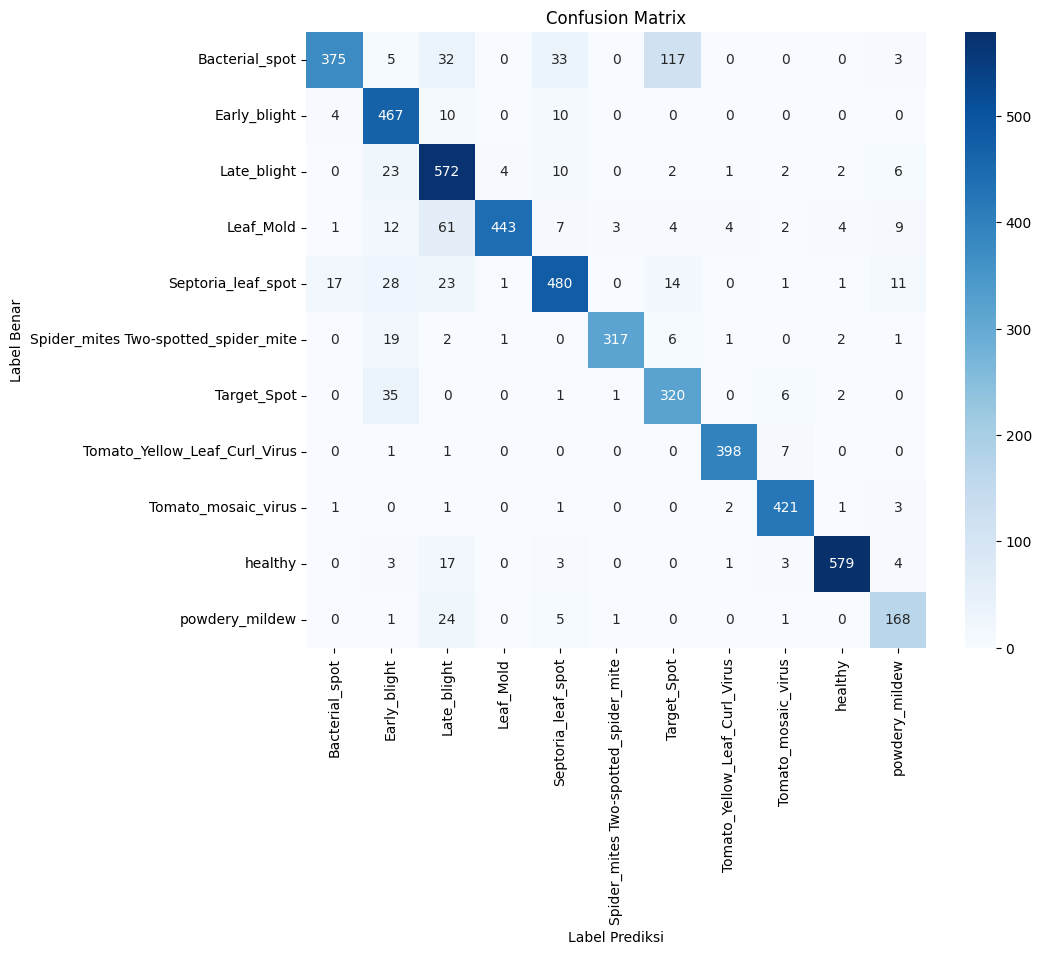

In [47]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta de predicción')
plt.ylabel('Etiqueta correcta')
plt.title('Matriz de confusión')
plt.show()

### MobileNetV2 2

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
pre_trained_model.add(layers.MaxPooling2D((2, 2)))

pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(layers.Dropout(0.5))
pre_trained_model.add(layers.Dense(11, activation='softmax'))

#Aplicamos optimizador Adam
pre_trained_model.compile(optimizer='adam',
               loss='categorical_crossentropy', #Labels no one-hot encoded
               metrics=['accuracy'])

In [ ]:
pre_trained_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,296,395 (12.57 MB)

 Trainable params: 3,262,283 (12.44 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
os.makedirs('/content/drive/MyDrive/TFM/MobileNetV2_2', exist_ok=True)

In [ ]:
history_checkpoint_callback = HistorySaver('/content/drive/MyDrive/TFM/MobileNetV2_2/train_history.json')

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/TFM/MobileNetV2_2/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
history = pre_trained_model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[checkpoint_callback, history_checkpoint_callback, early_stop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 433s 566ms/step - accuracy: 0.4865 - loss: 1.5762 - val_accuracy: 0.1257 - val_loss: 3.2756
Epoch 2/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 323s 498ms/step - accuracy: 0.7929 - loss: 0.6408 - val_accuracy: 0.2411 - val_loss: 2.5405
Epoch 3/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 318s 491ms/step - accuracy: 0.8319 - loss: 0.5161 - val_accuracy: 0.5746 - val_loss: 1.6045
Epoch 4/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 318s 492ms/step - accuracy: 0.8476 - loss: 0.4588 - val_accuracy: 0.6777 - val_loss: 1.1615
Epoch 5/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 322s 491ms/step - accuracy: 0.8520 - loss: 0.4641 - val_accuracy: 0.3491 - val_loss: 2.1634
Epoch 6/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 316s 488ms/step - accuracy: 0.8621 - loss: 0.4092 - val_accuracy: 0.1408 - val_loss: 2.3487
Epoch 7/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 319s 493ms/step - accuracy: 0.8554 - loss: 0.4308 - val_accuracy: 0.6928 - val_loss: 1.1087
Epoch 8/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 316s 488ms/step - accuracy: 0.8768 -

In [ ]:
# Load model
pre_trained_model = load_model('/content/drive/MyDrive/TFM/MobileNetV2_1/best_model.keras')

# Asegura que el generador no esté desordenado
test_generator.reset()
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Predicción
y_pred_probs = pre_trained_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


162/162 ━━━━━━━━━━━━━━━━━━━━ 27s 139ms/step
                                      precision    recall  f1-score   support

                      Bacterial_spot      0.942     0.664     0.779       565
                        Early_blight      0.786     0.951     0.861       491
                         Late_blight      0.770     0.920     0.838       622
                           Leaf_Mold      0.987     0.805     0.887       550
                  Septoria_leaf_spot      0.873     0.833     0.853       576
Spider_mites Two-spotted_spider_mite      0.984     0.908     0.945       349
                         Target_Spot      0.691     0.877     0.773       365
       Tomato_Yellow_Leaf_Curl_Virus      0.978     0.978     0.978       407
                 Tomato_mosaic_virus      0.950     0.979     0.964       430
                             healthy      0.980     0.949     0.964       610
                      powdery_mildew      0.820     0.840     0.830       200

                  

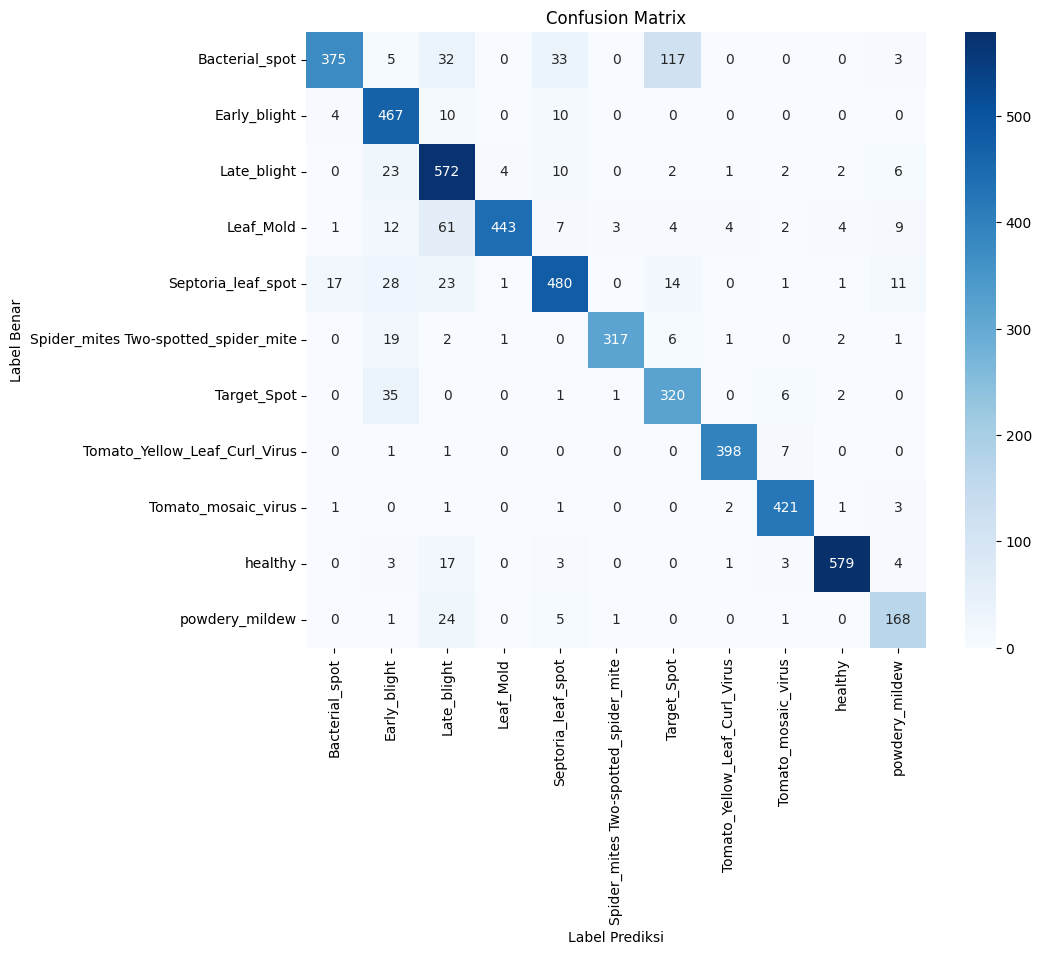

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta de predicción')
plt.ylabel('Etiqueta correcta')
plt.title('Matriz de confusión')
plt.show()

## Modelo x

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

## Modelo x

In [ ]:
from tensorflow.keras.applications import NASNetMobile